In [44]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [45]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [35]:
bs = 128

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()    
])

train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2)

In [65]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 1, 28, 28])

In [37]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Arsitektur & Config

In [38]:
from jcopdl.layers import linear_block

In [49]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout),
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, output_size, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [50]:
config = set_config({
    "input_size" : 784,
    "n1" : 256,
    "n2" : 64, 
    "dropout" : 0.2,
    "output_size" : len(train_set.classes)
})

# Training Preparation -> MCOC

In [51]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()  
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [52]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test": 
        model.eval()
    
    cost = correct = 0
    
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.7233 | Test_cost  = 0.4532 | Train_score = 0.7427 | Test_score = 0.8401 |




Epoch     2
Train_cost  = 0.4681 | Test_cost  = 0.4129 | Train_score = 0.8349 | Test_score = 0.8488 |




Epoch     3
Train_cost  = 0.4178 | Test_cost  = 0.3974 | Train_score = 0.8513 | Test_score = 0.8524 |




Epoch     4
Train_cost  = 0.3896 | Test_cost  = 0.3582 | Train_score = 0.8605 | Test_score = 0.8667 |




Epoch     5
Train_cost  = 0.3664 | Test_cost  = 0.3483 | Train_score = 0.8676 | Test_score = 0.8711 |




Epoch     6
Train_cost  = 0.3532 | Test_cost  = 0.3430 | Train_score = 0.8731 | Test_score = 0.8762 |




Epoch     7
Train_cost  = 0.3411 | Test_cost  = 0.3333 | Train_score = 0.8762 | Test_score = 0.8787 |




Epoch     8
Train_cost  = 0.3261 | Test_cost  = 0.3234 | Train_score = 0.8824 | Test_score = 0.8828 |




Epoch     9
Train_cost  = 0.3136 | Test_cost  = 0.3281 | Train_score = 0.8859 | Test_score = 0.8822 |
==> EarlyStop patience =  1 | Best test_score: 0.8828




Epoch    10
Train_cost  = 0.3079 | Test_cost  = 0.3240 | Train_score = 0.8891 | Test_score = 0.8821 |
==> EarlyStop patience =  2 | Best test_score: 0.8828




Epoch    11
Train_cost  = 0.2972 | Test_cost  = 0.3289 | Train_score = 0.8907 | Test_score = 0.8807 |
==> EarlyStop patience =  3 | Best test_score: 0.8828




Epoch    12
Train_cost  = 0.2929 | Test_cost  = 0.3098 | Train_score = 0.8925 | Test_score = 0.8861 |




Epoch    13
Train_cost  = 0.2869 | Test_cost  = 0.3105 | Train_score = 0.8950 | Test_score = 0.8853 |
==> EarlyStop patience =  1 | Best test_score: 0.8861




Epoch    14
Train_cost  = 0.2790 | Test_cost  = 0.3179 | Train_score = 0.8980 | Test_score = 0.8872 |




Epoch    15
Train_cost  = 0.2732 | Test_cost  = 0.3052 | Train_score = 0.8996 | Test_score = 0.8901 |




Epoch    16
Train_cost  = 0.2628 | Test_cost  = 0.3191 | Train_score = 0.9025 | Test_score = 0.8821 |
==> EarlyStop patience =  1 | Best test_score: 0.8901




Epoch    17
Train_cost  = 0.2629 | Test_cost  = 0.3017 | Train_score = 0.9020 | Test_score = 0.8932 |




Epoch    18
Train_cost  = 0.2588 | Test_cost  = 0.3106 | Train_score = 0.9038 | Test_score = 0.8876 |
==> EarlyStop patience =  1 | Best test_score: 0.8932




Epoch    19
Train_cost  = 0.2487 | Test_cost  = 0.3153 | Train_score = 0.9069 | Test_score = 0.8893 |
==> EarlyStop patience =  2 | Best test_score: 0.8932




Epoch    20
Train_cost  = 0.2469 | Test_cost  = 0.3132 | Train_score = 0.9079 | Test_score = 0.8886 |


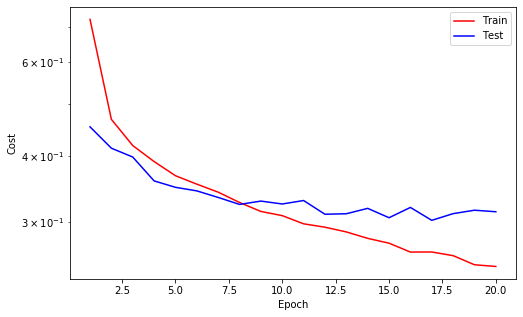

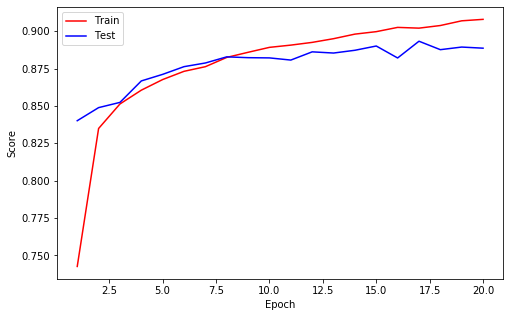

==> EarlyStop patience =  3 | Best test_score: 0.8932




Epoch    21
Train_cost  = 0.2414 | Test_cost  = 0.3096 | Train_score = 0.9105 | Test_score = 0.8905 |
==> EarlyStop patience =  4 | Best test_score: 0.8932




Epoch    22
Train_cost  = 0.2428 | Test_cost  = 0.3084 | Train_score = 0.9082 | Test_score = 0.8908 |
==> EarlyStop patience =  5 | Best test_score: 0.8932
==> Execute Early Stopping at epoch: 22 | Best test_score: 0.8932
==> Best model is saved at model


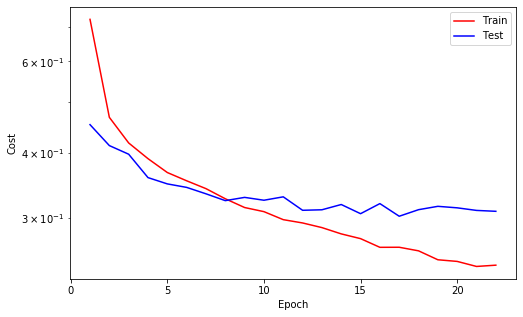

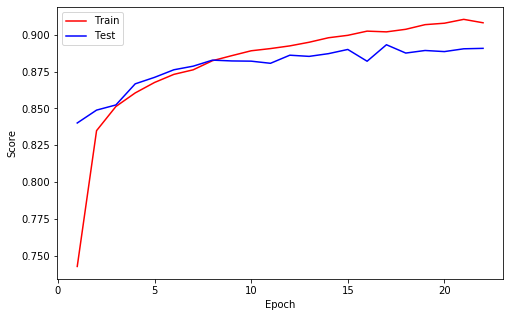

In [53]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break

# Load best model

In [ ]:
# weights = torch.load("model/weights_best.pth", map_location='cpu')
# config = torch.load("model/configs.pth", map_location='cpu')

# model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
# model.load_state_dict(weights)
# model = model.to(device)

# Predict

In [55]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [60]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred] for pred in preds]


['Dress',
 'Sneaker',
 'Dress',
 'Dress',
 'Coat',
 'Sandal',
 'Dress',
 'Sandal',
 'Trouser',
 'Pullover',
 'T-shirt or Top',
 'Sandal',
 'Bag',
 'Coat',
 'Coat',
 'Coat',
 'T-shirt or Top',
 'Coat',
 'Coat',
 'Sneaker',
 'Sandal',
 'Bag',
 'T-shirt or Top',
 'Ankle boot',
 'Bag',
 'T-shirt or Top',
 'Ankle boot',
 'Sneaker',
 'T-shirt or Top',
 'Sneaker',
 'Shirt',
 'Trouser',
 'Trouser',
 'Sneaker',
 'Sneaker',
 'Sandal',
 'T-shirt or Top',
 'Coat',
 'Trouser',
 'Shirt',
 'Ankle boot',
 'Coat',
 'Sneaker',
 'T-shirt or Top',
 'Bag',
 'Dress',
 'T-shirt or Top',
 'Ankle boot',
 'Shirt',
 'Ankle boot',
 'Pullover',
 'Sneaker',
 'Bag',
 'T-shirt or Top',
 'T-shirt or Top',
 'Dress',
 'Pullover',
 'Pullover',
 'Pullover',
 'Sandal',
 'Sneaker',
 'Shirt',
 'Bag',
 'Ankle boot',
 'Sandal',
 'Sandal',
 'Coat',
 'Bag',
 'Sneaker',
 'Trouser',
 'Shirt',
 'Coat',
 'T-shirt or Top',
 'Sandal',
 'Bag',
 'Bag',
 'Ankle boot',
 'Trouser',
 'Shirt',
 'T-shirt or Top',
 'Ankle boot',
 'Shirt',
 'Sh

# Visualisasi

In [61]:
import matplotlib.pyplot as plt

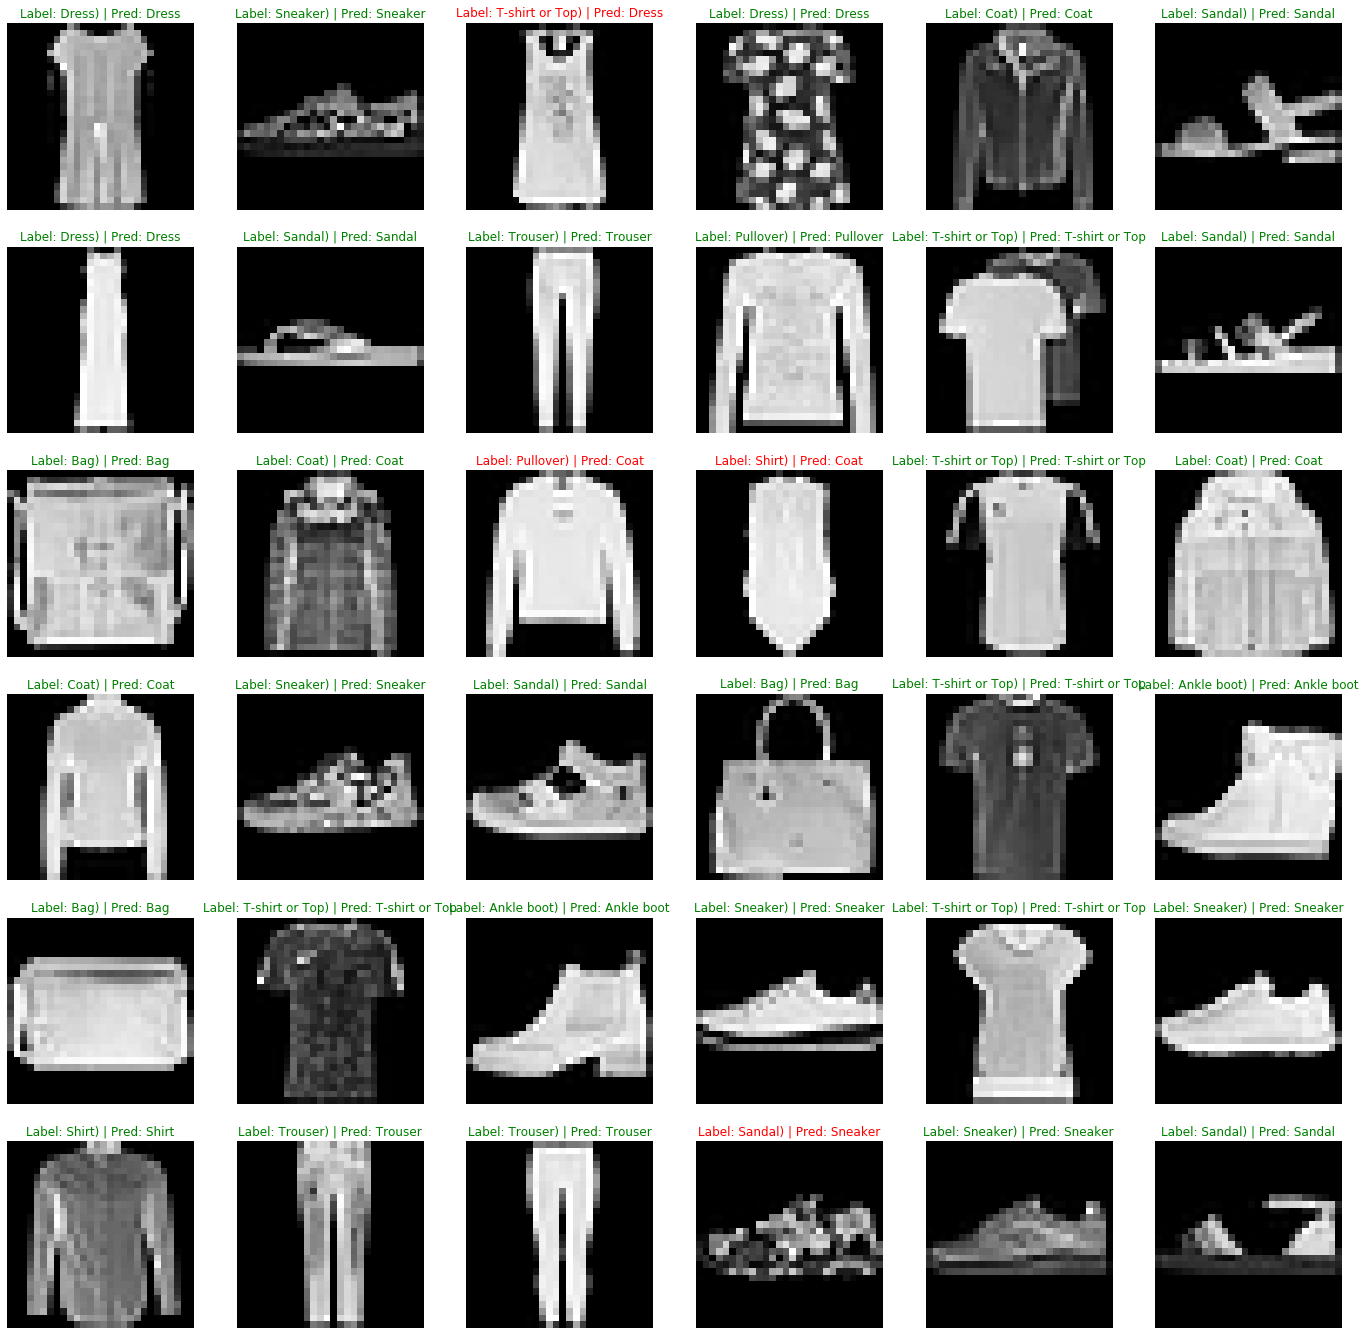

In [64]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28,28).cpu(), cmap='gray')
    font = {"color" : 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label}) | Pred: {pred}", fontdict=font);
    ax.axis('off');
    